In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
class TransformerMultiTask(nn.Module):
    def __init__(self, input_dim, num_heads:int, num_layers:int, hidden_dim:int, 
                 entity_id_cls:int, entity_state_cls:int, additional_input_dim:int = 0):
        super(TransformerMultiTask, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        
        transformer_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
        
        # Separate heads for classification tasks
        # Simpler actionable classification head
        self.actionable_fc = nn.Linear(hidden_dim + additional_input_dim, 2)
        
        # Head for complex entity ID classification
        self.entity_id_fc = nn.Sequential(
            nn.Linear(hidden_dim + additional_input_dim, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, entity_id_cls)
        )
        
        # Head for entity state classification
        #  - takes the additional inputs and also the outputs of the entity classifications
        self.entity_state_fc = nn.Sequential(
            nn.Linear(hidden_dim + additional_input_dim + entity_id_cls, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, entity_state_cls)
        )
        
    def forward(self, sequence, additional_inputs=None):
        # x shape: (batch_size, seq_length, input_dim)
        embed = self.embedding(sequence)
        x = self.transformer(embed)
        
        # Take the mean across the sequence dimension
        x = x.mean(dim=1)

        # If additional inputs are provided, concatenate them with x
        if additional_inputs is not None:
            x = torch.cat((x, additional_inputs), dim=-1)
        
        # Separate heads for classification and regression
        actionable_output = self.actionable_fc(x)
        entity_id_output = self.entity_id_fc(x)
        # Concatenate x with entity_id_output before passing to entity_state_fc
        x_with_entity_id = torch.cat((x, entity_id_output), dim=-1)
        entity_state_output = self.entity_state_fc(x_with_entity_id)
        
        # return actionable_output, entity_id_output, entity_state_output, time_pred_output
        return actionable_output, entity_id_output, entity_state_output

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader, IterableDataset
import os
import random
import io
import numpy as np
import pandas as pd
import warnings

# Helper function to convert bytes back to tensor
def bytes_to_tensor(tensor_bytes):
    buffer = io.BytesIO(tensor_bytes)
    loaded_tensor = torch.load(buffer, weights_only=True)
    return loaded_tensor

from torch.utils.data import DataLoader

class MultiPartParquetCASASDataset(IterableDataset):
    def __init__(self, file_list, shuffle_files=True, shuffle_rows=True):
        self.file_list = file_list
        self.shuffle_files = shuffle_files
        self.shuffle_rows = shuffle_rows
        
        if self.shuffle_files:
            random.shuffle(self.file_list)  # Shuffle the order of files

    def _read_parquet_file(self, file_path):
        df = pd.read_parquet(file_path)

        if self.shuffle_rows:
            df = df.sample(frac=1).reset_index(drop=True)  # Shuffle rows within the dataframe

        return df

    def __len__(self):
        total_len = 0
        for file in self.file_list:
            df = self._read_parquet_file(file)
            total_len += len(df)
        return total_len
    
    def __iter__(self):
        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)
            for file in self.file_list:
                df = self._read_parquet_file(file)
                for _, row in df.iterrows():
                    # shape(batch_size, sequence_length(var))
                    input_tensor = bytes_to_tensor(row['sequence']) 
                    # additional inputs
                    curr_time_hint_tensors = torch.tensor(row[['min', 'hour', 'day', 'week', 'month']])
                    # y labels
                    time_prediction_tensor = torch.tensor(row['secs_from_last'], dtype=torch.float32)
                    actionable_tensor = torch.tensor(not row['sensor_change'], dtype=torch.long)
                    action_entity_id_tensor = torch.tensor(row['changed_entity_id'], dtype=torch.long)
                    action_entity_state_tensor = torch.tensor(float(row['changed_entity_value']), dtype=torch.long)
    
                    yield input_tensor, curr_time_hint_tensors, time_prediction_tensor, actionable_tensor, action_entity_id_tensor, action_entity_state_tensor


def split_file_list(file_list, train_ratio=0.8, test_ratio=0.1, eval_ratio=0.1):
    """
    Split the list of files into train/test/eval based on the given ratios.
    """
    assert train_ratio + test_ratio + eval_ratio == 1.0, "Ratios must sum to 1"
    
    # Shuffle the file list to ensure randomness
    random.shuffle(file_list)
    
    # Split based on the ratio
    total_files = len(file_list)
    train_end = int(train_ratio * total_files)
    test_end = train_end + int(test_ratio * total_files)
    
    train_files = file_list[:train_end]
    test_files = file_list[train_end:test_end]
    eval_files = file_list[test_end:]
    
    return train_files, test_files, eval_files

def _collate_fn(batch):
    # Separate inputs and targets
    input_tensors, curr_time_hint_tensors, time_prediction_tensors, actionable_tensors, action_entity_id_tensors, action_entity_state_tensors = zip(*batch)
    
    # Pad sequences for inputs (batch_first=True makes it [batch_size, seq_len, features])
    input_tensors_padded = pad_sequence(input_tensors, batch_first=True)
    # stack the additional inputs
    curr_time_hint_tensors = torch.stack(curr_time_hint_tensors)
    
    # Convert targets to tensors (they should all have the same length as they're scalar values)
    time_prediction_tensors = torch.stack(time_prediction_tensors)
    actionable_tensors = torch.stack(actionable_tensors)
    action_entity_id_tensors = torch.stack(action_entity_id_tensors)
    action_entity_state_tensors = torch.stack(action_entity_state_tensors)
    
    return input_tensors_padded, curr_time_hint_tensors, time_prediction_tensors, actionable_tensors, action_entity_id_tensors, action_entity_state_tensors


In [5]:
import torch
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence

def train_act_model(model, train_loader, eval_loader, num_epochs, 
                actionable_classification_criterion, 
                entity_id_classification_criterion, 
                entity_state_classification_criterion, 
                optimizer, device):
    # Store accuracies and time prediction losses
    actionable_accuracies = []
    entity_id_accuracies = []
    entity_state_accuracies = []
    
    model.to(device)
    # note: the train() method resets the drop out and layer norm when called, so it should not be called for every epoch or otherwise it won't converge (transformer uses batch norm and drop out)
    #  see https://pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.train
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        correct_entity_state = 0
        total_entity_state = 0
        correct_entity_id = 0
        total_entity_id = 0
        
        for batch_idx, (input_tensors_padded, curr_time_hint_tensors, time_prediction_tensors, actionable_tensors, action_entity_id_tensors, action_entity_state_tensors) in tqdm(enumerate(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}"):
            # Assuming the train_loader returns a dictionary-like batch with relevant keys
            inputs = input_tensors_padded.to(device)  # shape: (batch_size, max_seq_length, input_dim)
            time_hint_inputs = curr_time_hint_tensors.to(device)
            actionable_labels = actionable_tensors.to(device)  # shape: (batch_size,)
            entity_id_labels = action_entity_id_tensors.to(device)  # shape: (batch_size,)
            entity_state_labels = action_entity_state_tensors.to(device)  # shape: (batch_size,)

            optimizer.zero_grad()

            # Forward pass
            actionable_output, entity_id_output, entity_state_output = model(inputs, additional_inputs=time_hint_inputs)
            
            # Compute losses
            entity_id_loss = entity_id_classification_criterion(entity_id_output, entity_id_labels)
            entity_state_loss = entity_state_classification_criterion(entity_state_output, entity_state_labels)

            # Total loss
            total_loss = entity_id_loss * 8 + entity_state_loss * 2
            
            # Backward pass and optimization
            total_loss.backward()
            optimizer.step()
            
            epoch_loss += total_loss.item()

            
            # Calculate entity ID classification accuracy
            _, predicted_entity_id = torch.max(entity_id_output, 1)
            correct_entity_id += (predicted_entity_id == entity_id_labels).sum().item()
            total_entity_id += entity_id_labels.size(0)

            # Calculate entity state classification accuracy
            _, predicted_entity_state = torch.max(entity_state_output, 1)
            correct_entity_state += (predicted_entity_state == entity_state_labels).sum().item()
            total_entity_state += entity_state_labels.size(0)
            
        # Print epoch stats
        avg_loss = epoch_loss / len(train_loader)

        entity_id_accuracy = 100 * correct_entity_id / total_entity_id
        entity_id_accuracies.append(entity_id_accuracy)
        entity_state_accuracy = 100 * correct_entity_state / total_entity_state
        entity_state_accuracies.append(entity_state_accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Entity ID Acc: {entity_id_accuracy:.4f}%, Entity state Acc: {entity_state_accuracy:.2f}%")
        
    print("Act Training Complete!")
    return actionable_accuracies, entity_id_accuracies, entity_state_accuracies

In [6]:
from os import listdir
from os.path import isfile, join
import re
data_root_path = './data/training_act'
data_pattern = r"^training_data_chunk_slim_\d+\.parquet"
file_list = [join(data_root_path, f) for f in listdir(data_root_path) if isfile(join(data_root_path, f)) and re.match(data_pattern, f)][:100]
# Split the file list
train_files, test_files, eval_files = split_file_list(file_list, train_ratio=0.8, test_ratio=0.0, eval_ratio=0.2)
print(f'{train_files}, {test_files}, {eval_files}')
# Create separate datasets
train_dataset = MultiPartParquetCASASDataset(train_files, shuffle_files=True, shuffle_rows=True)
test_dataset = MultiPartParquetCASASDataset(test_files, shuffle_files=False, shuffle_rows=False)
eval_dataset = MultiPartParquetCASASDataset(eval_files, shuffle_files=False, shuffle_rows=False)

# Wrap them in DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, collate_fn=_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=_collate_fn)
eval_loader = DataLoader(eval_dataset, batch_size=64, shuffle=False, collate_fn=_collate_fn)


# Actionable Classification Criterion (binary classification)
actionable_classification_criterion = nn.CrossEntropyLoss()

# Entity ID Classification Criterion (multi-class classification)
entity_id_classification_criterion = nn.CrossEntropyLoss()

# Entity State Classification Criterion (multi-class classification)
entity_state_classification_criterion = nn.CrossEntropyLoss()



['./data/training_act/training_data_chunk_slim_5.parquet', './data/training_act/training_data_chunk_slim_2.parquet', './data/training_act/training_data_chunk_slim_1.parquet', './data/training_act/training_data_chunk_slim_3.parquet'], [], ['./data/training_act/training_data_chunk_slim_4.parquet']


In [6]:
# define the model
model = TransformerMultiTask(input_dim=46, hidden_dim=512, additional_input_dim=5, num_heads=2, num_layers=1, entity_id_cls=45, entity_state_cls=4)
training_epoch = 128
# Using Adam optimizer
import torch.optim as optim
learning_rate = 1e-4  # You can adjust the learning rate as needed
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# find the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# start the training
_, entity_id_accuracies, entity_state_accuracies = train_act_model(model=model, train_loader=train_loader, eval_loader=eval_loader, num_epochs=training_epoch, 
            actionable_classification_criterion=actionable_classification_criterion, 
            entity_id_classification_criterion=entity_id_classification_criterion, 
            entity_state_classification_criterion=entity_state_classification_criterion, 
            optimizer=optimizer, device=device)

Epoch 1/128: 15it [00:06,  2.34it/s]


Epoch [1/128], Loss: 26.9933, Entity ID Acc: 10.5932%, Entity state Acc: 52.65%


Epoch 2/128: 15it [00:05,  2.82it/s]


Epoch [2/128], Loss: 22.0444, Entity ID Acc: 14.8305%, Entity state Acc: 56.67%


Epoch 3/128: 15it [00:05,  2.87it/s]


Epoch [3/128], Loss: 20.0501, Entity ID Acc: 23.3051%, Entity state Acc: 59.75%


Epoch 4/128: 15it [00:05,  2.73it/s]


Epoch [4/128], Loss: 19.3188, Entity ID Acc: 24.1525%, Entity state Acc: 60.70%


Epoch 5/128: 15it [00:05,  2.87it/s]


Epoch [5/128], Loss: 18.6857, Entity ID Acc: 27.0127%, Entity state Acc: 61.76%


Epoch 6/128: 15it [00:05,  2.77it/s]


Epoch [6/128], Loss: 18.2354, Entity ID Acc: 28.1780%, Entity state Acc: 61.23%


Epoch 7/128: 15it [00:05,  2.69it/s]


Epoch [7/128], Loss: 17.9113, Entity ID Acc: 27.9661%, Entity state Acc: 58.90%


Epoch 8/128: 15it [00:05,  2.83it/s]


Epoch [8/128], Loss: 17.6606, Entity ID Acc: 29.9788%, Entity state Acc: 59.75%


Epoch 9/128: 15it [00:05,  2.88it/s]


Epoch [9/128], Loss: 17.3771, Entity ID Acc: 31.0381%, Entity state Acc: 59.75%


Epoch 10/128: 15it [00:05,  2.80it/s]


Epoch [10/128], Loss: 17.1304, Entity ID Acc: 31.6737%, Entity state Acc: 61.12%


Epoch 11/128: 15it [00:05,  2.72it/s]


Epoch [11/128], Loss: 16.7667, Entity ID Acc: 34.3220%, Entity state Acc: 61.44%


Epoch 12/128: 15it [00:05,  2.76it/s]


Epoch [12/128], Loss: 16.5408, Entity ID Acc: 33.4746%, Entity state Acc: 63.03%


Epoch 13/128: 15it [00:05,  2.72it/s]


Epoch [13/128], Loss: 16.2908, Entity ID Acc: 33.8983%, Entity state Acc: 61.97%


Epoch 14/128: 15it [00:05,  2.60it/s]


Epoch [14/128], Loss: 16.1454, Entity ID Acc: 36.4407%, Entity state Acc: 62.18%


Epoch 15/128: 15it [00:05,  2.70it/s]


Epoch [15/128], Loss: 15.7769, Entity ID Acc: 37.7119%, Entity state Acc: 61.55%


Epoch 16/128: 15it [00:05,  2.54it/s]


Epoch [16/128], Loss: 15.0168, Entity ID Acc: 42.2669%, Entity state Acc: 62.92%


Epoch 17/128: 15it [00:05,  2.71it/s]


Epoch [17/128], Loss: 14.8583, Entity ID Acc: 42.1610%, Entity state Acc: 62.39%


Epoch 18/128: 15it [00:05,  2.70it/s]


Epoch [18/128], Loss: 13.8683, Entity ID Acc: 46.3983%, Entity state Acc: 63.14%


Epoch 19/128: 15it [00:05,  2.64it/s]


Epoch [19/128], Loss: 14.4214, Entity ID Acc: 41.7373%, Entity state Acc: 60.70%


Epoch 20/128: 15it [00:06,  2.34it/s]


Epoch [20/128], Loss: 13.4142, Entity ID Acc: 47.3517%, Entity state Acc: 62.61%


Epoch 21/128: 15it [00:07,  2.09it/s]


Epoch [21/128], Loss: 12.4255, Entity ID Acc: 52.5424%, Entity state Acc: 62.18%


Epoch 22/128: 15it [00:06,  2.17it/s]


Epoch [22/128], Loss: 11.7168, Entity ID Acc: 58.1568%, Entity state Acc: 62.39%


Epoch 23/128: 15it [00:05,  2.56it/s]


Epoch [23/128], Loss: 11.2830, Entity ID Acc: 58.6864%, Entity state Acc: 65.25%


Epoch 24/128: 15it [00:05,  2.71it/s]


Epoch [24/128], Loss: 10.0457, Entity ID Acc: 64.8305%, Entity state Acc: 62.92%


Epoch 25/128: 15it [00:05,  2.71it/s]


Epoch [25/128], Loss: 10.1482, Entity ID Acc: 64.6186%, Entity state Acc: 62.92%


Epoch 26/128: 15it [00:05,  2.79it/s]


Epoch [26/128], Loss: 10.7574, Entity ID Acc: 59.4280%, Entity state Acc: 64.19%


Epoch 27/128: 15it [00:05,  2.68it/s]


Epoch [27/128], Loss: 10.4024, Entity ID Acc: 60.4873%, Entity state Acc: 63.77%


Epoch 28/128: 15it [00:06,  2.35it/s]


Epoch [28/128], Loss: 9.5914, Entity ID Acc: 63.7712%, Entity state Acc: 65.25%


Epoch 29/128: 15it [00:05,  2.51it/s]


Epoch [29/128], Loss: 9.4797, Entity ID Acc: 63.6653%, Entity state Acc: 65.47%


Epoch 30/128: 15it [00:05,  2.72it/s]


Epoch [30/128], Loss: 11.7173, Entity ID Acc: 55.2966%, Entity state Acc: 64.83%


Epoch 31/128: 15it [00:05,  2.66it/s]


Epoch [31/128], Loss: 8.7354, Entity ID Acc: 68.0085%, Entity state Acc: 64.72%


Epoch 32/128: 15it [00:06,  2.38it/s]


Epoch [32/128], Loss: 8.8338, Entity ID Acc: 68.1144%, Entity state Acc: 62.08%


Epoch 33/128: 15it [00:05,  2.57it/s]


Epoch [33/128], Loss: 7.6344, Entity ID Acc: 74.2585%, Entity state Acc: 66.53%


Epoch 34/128: 15it [00:05,  2.64it/s]


Epoch [34/128], Loss: 6.9780, Entity ID Acc: 77.0127%, Entity state Acc: 67.27%


Epoch 35/128: 15it [00:05,  2.64it/s]


Epoch [35/128], Loss: 6.7555, Entity ID Acc: 77.6483%, Entity state Acc: 62.92%


Epoch 36/128: 15it [00:05,  2.64it/s]


Epoch [36/128], Loss: 6.4574, Entity ID Acc: 79.1314%, Entity state Acc: 68.01%


Epoch 37/128: 15it [00:05,  2.65it/s]


Epoch [37/128], Loss: 5.6546, Entity ID Acc: 84.4280%, Entity state Acc: 67.16%


Epoch 38/128: 15it [00:05,  2.58it/s]


Epoch [38/128], Loss: 5.5555, Entity ID Acc: 81.7797%, Entity state Acc: 70.97%


Epoch 39/128: 15it [00:05,  2.55it/s]


Epoch [39/128], Loss: 5.1603, Entity ID Acc: 84.4280%, Entity state Acc: 74.26%


Epoch 40/128: 15it [00:06,  2.48it/s]


Epoch [40/128], Loss: 5.6245, Entity ID Acc: 83.3686%, Entity state Acc: 69.28%


Epoch 41/128: 15it [00:05,  2.57it/s]


Epoch [41/128], Loss: 6.8497, Entity ID Acc: 75.8475%, Entity state Acc: 73.31%


Epoch 42/128: 15it [00:05,  2.63it/s]


Epoch [42/128], Loss: 7.2460, Entity ID Acc: 74.2585%, Entity state Acc: 72.88%


Epoch 43/128: 15it [00:05,  2.73it/s]


Epoch [43/128], Loss: 6.3254, Entity ID Acc: 76.1653%, Entity state Acc: 70.34%


Epoch 44/128: 15it [00:05,  2.77it/s]


Epoch [44/128], Loss: 5.4859, Entity ID Acc: 81.4619%, Entity state Acc: 73.31%


Epoch 45/128: 15it [00:05,  2.79it/s]


Epoch [45/128], Loss: 5.2582, Entity ID Acc: 82.3093%, Entity state Acc: 73.62%


Epoch 46/128: 15it [00:05,  2.75it/s]


Epoch [46/128], Loss: 5.0136, Entity ID Acc: 84.1102%, Entity state Acc: 75.00%


Epoch 47/128: 15it [00:05,  2.74it/s]


Epoch [47/128], Loss: 4.5700, Entity ID Acc: 85.3814%, Entity state Acc: 77.01%


Epoch 48/128: 15it [00:05,  2.74it/s]


Epoch [48/128], Loss: 4.2475, Entity ID Acc: 86.1229%, Entity state Acc: 77.65%


Epoch 49/128: 15it [00:05,  2.73it/s]


Epoch [49/128], Loss: 4.5744, Entity ID Acc: 84.4280%, Entity state Acc: 76.80%


Epoch 50/128: 15it [00:05,  2.54it/s]


Epoch [50/128], Loss: 3.8872, Entity ID Acc: 88.3475%, Entity state Acc: 77.12%


Epoch 51/128: 15it [00:06,  2.45it/s]


Epoch [51/128], Loss: 4.4679, Entity ID Acc: 84.9576%, Entity state Acc: 80.51%


Epoch 52/128: 15it [00:06,  2.46it/s]


Epoch [52/128], Loss: 3.7703, Entity ID Acc: 88.9831%, Entity state Acc: 80.40%


Epoch 53/128: 15it [00:06,  2.47it/s]


Epoch [53/128], Loss: 3.1143, Entity ID Acc: 92.0551%, Entity state Acc: 77.33%


Epoch 54/128: 15it [00:06,  2.46it/s]


Epoch [54/128], Loss: 2.8119, Entity ID Acc: 92.9025%, Entity state Acc: 79.98%


Epoch 55/128: 15it [00:05,  2.71it/s]


Epoch [55/128], Loss: 2.9623, Entity ID Acc: 91.9492%, Entity state Acc: 81.25%


Epoch 56/128: 15it [00:06,  2.33it/s]


Epoch [56/128], Loss: 2.6412, Entity ID Acc: 93.3263%, Entity state Acc: 83.16%


Epoch 57/128: 15it [00:05,  2.60it/s]


Epoch [57/128], Loss: 2.7238, Entity ID Acc: 92.6907%, Entity state Acc: 80.93%


Epoch 58/128: 15it [00:05,  2.50it/s]


Epoch [58/128], Loss: 3.1136, Entity ID Acc: 90.9958%, Entity state Acc: 79.45%


Epoch 59/128: 15it [00:05,  2.77it/s]


Epoch [59/128], Loss: 2.7415, Entity ID Acc: 92.6907%, Entity state Acc: 81.78%


Epoch 60/128: 15it [00:05,  2.95it/s]


Epoch [60/128], Loss: 2.6588, Entity ID Acc: 93.3263%, Entity state Acc: 82.20%


Epoch 61/128: 15it [00:05,  2.52it/s]


Epoch [61/128], Loss: 2.1830, Entity ID Acc: 95.4449%, Entity state Acc: 82.52%


Epoch 62/128: 15it [00:05,  2.64it/s]


Epoch [62/128], Loss: 1.9906, Entity ID Acc: 95.7627%, Entity state Acc: 86.86%


Epoch 63/128: 15it [00:05,  2.71it/s]


Epoch [63/128], Loss: 2.5490, Entity ID Acc: 93.7500%, Entity state Acc: 83.69%


Epoch 64/128: 15it [00:05,  2.64it/s]


Epoch [64/128], Loss: 2.9698, Entity ID Acc: 91.7373%, Entity state Acc: 80.30%


Epoch 65/128: 15it [00:05,  2.59it/s]


Epoch [65/128], Loss: 2.7797, Entity ID Acc: 92.1610%, Entity state Acc: 83.16%


Epoch 66/128: 15it [00:06,  2.40it/s]


Epoch [66/128], Loss: 2.2854, Entity ID Acc: 94.4915%, Entity state Acc: 86.33%


Epoch 67/128: 15it [00:05,  2.61it/s]


Epoch [67/128], Loss: 1.9211, Entity ID Acc: 95.6568%, Entity state Acc: 89.41%


Epoch 68/128: 15it [00:05,  2.74it/s]


Epoch [68/128], Loss: 1.8375, Entity ID Acc: 95.3390%, Entity state Acc: 86.65%


Epoch 69/128: 15it [00:05,  2.77it/s]


Epoch [69/128], Loss: 1.6850, Entity ID Acc: 96.9280%, Entity state Acc: 86.55%


Epoch 70/128: 15it [00:05,  2.77it/s]


Epoch [70/128], Loss: 1.5244, Entity ID Acc: 97.2458%, Entity state Acc: 91.31%


Epoch 71/128: 15it [00:05,  2.79it/s]


Epoch [71/128], Loss: 1.3492, Entity ID Acc: 96.9280%, Entity state Acc: 92.06%


Epoch 72/128: 15it [00:05,  2.75it/s]


Epoch [72/128], Loss: 1.3105, Entity ID Acc: 97.3517%, Entity state Acc: 91.95%


Epoch 73/128: 15it [00:05,  2.74it/s]


Epoch [73/128], Loss: 1.3381, Entity ID Acc: 97.5636%, Entity state Acc: 90.25%


Epoch 74/128: 15it [00:05,  2.51it/s]


Epoch [74/128], Loss: 1.1618, Entity ID Acc: 97.8814%, Entity state Acc: 93.75%


Epoch 75/128: 15it [00:05,  2.65it/s]


Epoch [75/128], Loss: 1.2016, Entity ID Acc: 98.0932%, Entity state Acc: 92.80%


Epoch 76/128: 15it [00:05,  2.59it/s]


Epoch [76/128], Loss: 1.0301, Entity ID Acc: 98.1992%, Entity state Acc: 93.11%


Epoch 77/128: 15it [00:05,  2.71it/s]


Epoch [77/128], Loss: 1.2099, Entity ID Acc: 97.5636%, Entity state Acc: 92.69%


Epoch 78/128: 15it [00:05,  2.65it/s]


Epoch [78/128], Loss: 1.3250, Entity ID Acc: 96.8220%, Entity state Acc: 92.90%


Epoch 79/128: 15it [00:05,  2.65it/s]


Epoch [79/128], Loss: 1.0387, Entity ID Acc: 98.5169%, Entity state Acc: 93.01%


Epoch 80/128: 15it [00:05,  2.65it/s]


Epoch [80/128], Loss: 1.0391, Entity ID Acc: 97.8814%, Entity state Acc: 93.54%


Epoch 81/128: 15it [00:05,  2.65it/s]


Epoch [81/128], Loss: 1.0797, Entity ID Acc: 97.4576%, Entity state Acc: 92.69%


Epoch 82/128: 15it [00:05,  2.51it/s]


Epoch [82/128], Loss: 1.0856, Entity ID Acc: 98.0932%, Entity state Acc: 93.33%


Epoch 83/128: 15it [00:05,  2.58it/s]


Epoch [83/128], Loss: 0.9490, Entity ID Acc: 98.0932%, Entity state Acc: 93.75%


Epoch 84/128: 15it [00:05,  2.66it/s]


Epoch [84/128], Loss: 0.9938, Entity ID Acc: 97.9873%, Entity state Acc: 94.70%


Epoch 85/128: 15it [00:06,  2.45it/s]


Epoch [85/128], Loss: 0.8615, Entity ID Acc: 98.6229%, Entity state Acc: 95.13%


Epoch 86/128: 15it [00:05,  2.58it/s]


Epoch [86/128], Loss: 0.8191, Entity ID Acc: 98.4110%, Entity state Acc: 96.08%


Epoch 87/128: 15it [00:05,  2.65it/s]


Epoch [87/128], Loss: 0.7932, Entity ID Acc: 98.5169%, Entity state Acc: 95.02%


Epoch 88/128: 15it [00:05,  2.67it/s]


Epoch [88/128], Loss: 0.6774, Entity ID Acc: 98.7288%, Entity state Acc: 95.44%


Epoch 89/128: 15it [00:05,  2.66it/s]


Epoch [89/128], Loss: 0.6347, Entity ID Acc: 98.9407%, Entity state Acc: 95.23%


Epoch 90/128: 15it [00:05,  2.68it/s]


Epoch [90/128], Loss: 0.6796, Entity ID Acc: 98.4110%, Entity state Acc: 95.23%


Epoch 91/128: 15it [00:05,  2.59it/s]


Epoch [91/128], Loss: 0.6926, Entity ID Acc: 98.8347%, Entity state Acc: 95.55%


Epoch 92/128: 15it [00:05,  2.52it/s]


Epoch [92/128], Loss: 0.7731, Entity ID Acc: 97.9873%, Entity state Acc: 94.60%


Epoch 93/128: 15it [00:05,  2.70it/s]


Epoch [93/128], Loss: 0.6563, Entity ID Acc: 98.8347%, Entity state Acc: 95.97%


Epoch 94/128: 15it [00:05,  2.62it/s]


Epoch [94/128], Loss: 0.5957, Entity ID Acc: 99.0466%, Entity state Acc: 96.29%


Epoch 95/128: 15it [00:05,  2.60it/s]


Epoch [95/128], Loss: 0.6645, Entity ID Acc: 99.1525%, Entity state Acc: 95.87%


Epoch 96/128: 15it [00:05,  2.75it/s]


Epoch [96/128], Loss: 0.6652, Entity ID Acc: 98.3051%, Entity state Acc: 95.87%


Epoch 97/128: 15it [00:05,  2.60it/s]


Epoch [97/128], Loss: 0.6506, Entity ID Acc: 98.6229%, Entity state Acc: 96.29%


Epoch 98/128: 15it [00:05,  2.80it/s]


Epoch [98/128], Loss: 0.6203, Entity ID Acc: 98.8347%, Entity state Acc: 95.34%


Epoch 99/128: 15it [00:05,  2.63it/s]


Epoch [99/128], Loss: 0.5503, Entity ID Acc: 99.1525%, Entity state Acc: 96.19%


Epoch 100/128: 15it [00:05,  2.62it/s]


Epoch [100/128], Loss: 0.5774, Entity ID Acc: 98.7288%, Entity state Acc: 97.14%


Epoch 101/128: 15it [00:05,  2.65it/s]


Epoch [101/128], Loss: 0.4789, Entity ID Acc: 99.5763%, Entity state Acc: 97.25%


Epoch 102/128: 15it [00:05,  2.68it/s]


Epoch [102/128], Loss: 0.5826, Entity ID Acc: 99.1525%, Entity state Acc: 96.93%


Epoch 103/128: 15it [00:06,  2.42it/s]


Epoch [103/128], Loss: 0.4857, Entity ID Acc: 99.0466%, Entity state Acc: 97.35%


Epoch 104/128: 15it [00:05,  2.59it/s]


Epoch [104/128], Loss: 0.5069, Entity ID Acc: 99.1525%, Entity state Acc: 97.14%


Epoch 105/128: 15it [00:05,  2.66it/s]


Epoch [105/128], Loss: 0.4575, Entity ID Acc: 99.0466%, Entity state Acc: 97.78%


Epoch 106/128: 15it [00:06,  2.42it/s]


Epoch [106/128], Loss: 0.5544, Entity ID Acc: 98.8347%, Entity state Acc: 96.40%


Epoch 107/128: 15it [00:05,  2.52it/s]


Epoch [107/128], Loss: 0.5207, Entity ID Acc: 99.1525%, Entity state Acc: 97.46%


Epoch 108/128: 15it [00:05,  2.78it/s]


Epoch [108/128], Loss: 0.5636, Entity ID Acc: 98.7288%, Entity state Acc: 97.14%


Epoch 109/128: 15it [00:05,  2.74it/s]


Epoch [109/128], Loss: 0.5422, Entity ID Acc: 99.0466%, Entity state Acc: 97.25%


Epoch 110/128: 15it [00:05,  2.86it/s]


Epoch [110/128], Loss: 0.4788, Entity ID Acc: 99.2585%, Entity state Acc: 97.56%


Epoch 111/128: 15it [00:05,  2.73it/s]


Epoch [111/128], Loss: 0.5258, Entity ID Acc: 98.9407%, Entity state Acc: 96.61%


Epoch 112/128: 15it [00:05,  2.56it/s]


Epoch [112/128], Loss: 0.5351, Entity ID Acc: 98.6229%, Entity state Acc: 97.67%


Epoch 113/128: 15it [00:05,  2.74it/s]


Epoch [113/128], Loss: 0.8391, Entity ID Acc: 98.6229%, Entity state Acc: 94.49%


Epoch 114/128: 15it [00:06,  2.36it/s]


Epoch [114/128], Loss: 0.5632, Entity ID Acc: 98.7288%, Entity state Acc: 96.29%


Epoch 115/128: 15it [00:05,  2.58it/s]


Epoch [115/128], Loss: 0.5958, Entity ID Acc: 98.9407%, Entity state Acc: 94.28%


Epoch 116/128: 15it [00:05,  2.62it/s]


Epoch [116/128], Loss: 0.5004, Entity ID Acc: 99.0466%, Entity state Acc: 96.82%


Epoch 117/128: 15it [00:05,  2.76it/s]


Epoch [117/128], Loss: 0.6105, Entity ID Acc: 98.9407%, Entity state Acc: 96.40%


Epoch 118/128: 15it [00:05,  2.65it/s]


Epoch [118/128], Loss: 0.4701, Entity ID Acc: 99.0466%, Entity state Acc: 97.25%


Epoch 119/128: 15it [00:05,  2.65it/s]


Epoch [119/128], Loss: 0.4257, Entity ID Acc: 98.7288%, Entity state Acc: 97.78%


Epoch 120/128: 15it [00:05,  2.66it/s]


Epoch [120/128], Loss: 0.4444, Entity ID Acc: 99.1525%, Entity state Acc: 97.14%


Epoch 121/128: 15it [00:05,  2.61it/s]


Epoch [121/128], Loss: 0.5278, Entity ID Acc: 98.9407%, Entity state Acc: 96.93%


Epoch 122/128: 15it [00:05,  2.66it/s]


Epoch [122/128], Loss: 0.3843, Entity ID Acc: 99.1525%, Entity state Acc: 98.31%


Epoch 123/128: 15it [00:05,  2.56it/s]


Epoch [123/128], Loss: 0.4366, Entity ID Acc: 99.3644%, Entity state Acc: 97.99%


Epoch 124/128: 15it [00:05,  2.63it/s]


Epoch [124/128], Loss: 0.4447, Entity ID Acc: 99.4703%, Entity state Acc: 97.25%


Epoch 125/128: 15it [00:05,  2.63it/s]


Epoch [125/128], Loss: 0.7435, Entity ID Acc: 98.1992%, Entity state Acc: 93.75%


Epoch 126/128: 15it [00:05,  2.63it/s]


Epoch [126/128], Loss: 0.9121, Entity ID Acc: 98.0932%, Entity state Acc: 91.53%


Epoch 127/128: 15it [00:05,  2.69it/s]


Epoch [127/128], Loss: 0.6683, Entity ID Acc: 98.7288%, Entity state Acc: 94.60%


Epoch 128/128: 15it [00:05,  2.72it/s]

Epoch [128/128], Loss: 0.5889, Entity ID Acc: 99.1525%, Entity state Acc: 95.76%
Act Training Complete!


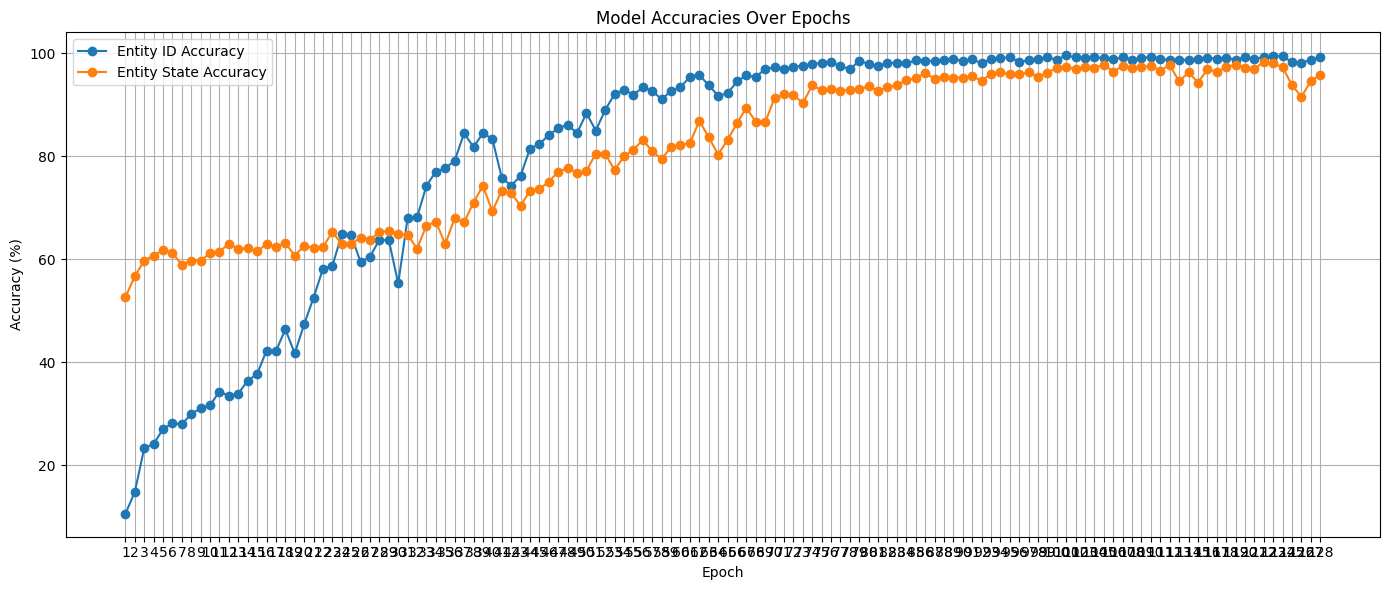

In [8]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 1, 1)
plt.plot(range(1, training_epoch + 1), entity_id_accuracies, marker='o', label='Entity ID Accuracy')
plt.plot(range(1, training_epoch + 1), entity_state_accuracies, marker='o', label='Entity State Accuracy')
plt.title('Model Accuracies Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, training_epoch + 1))  # Set x-ticks to match epoch numbers
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [14]:
torch.save(model.state_dict(), 'transformer_multi_task_slim_128.pth')

In [8]:
def eval_model(model, eval_loader, device=device):
    model.eval()
    with torch.no_grad():
        eval_correct_entity_id = 0
        eval_total_entity_id = 0
        eval_correct_entity_state = 0
        eval_total_entity_state = 0
        eval_loss = 0.0

        for eval_batch in eval_loader:
            eval_inputs = eval_batch[0].to(device)
            eval_time_hint_inputs = eval_batch[1].to(device)
            eval_entity_id_labels = eval_batch[4].to(device)
            eval_entity_state_labels = eval_batch[5].to(device)

            eval_actionable_output, eval_entity_id_output, eval_entity_state_output = model(eval_inputs, additional_inputs=eval_time_hint_inputs)    
            
            # Calculate eval entity ID classification accuracy
            _, eval_predicted_entity_id = torch.max(eval_entity_id_output, 1)
            eval_correct_entity_id += (eval_predicted_entity_id == eval_entity_id_labels).sum().item()
            eval_total_entity_id += eval_entity_id_labels.size(0)

            # Calculate eval entity state classification accuracy
            _, eval_predicted_entity_state = torch.max(eval_entity_state_output, 1)
            eval_correct_entity_state += (eval_predicted_entity_state == eval_entity_state_labels).sum().item()
            eval_total_entity_state += eval_entity_state_labels.size(0)

        eval_entity_id_accuracy = 100 * eval_correct_entity_id / eval_total_entity_id
        eval_entity_state_accuracy = 100 * eval_correct_entity_state / eval_total_entity_state
        print(f"Eval Entity ID Acc: {eval_entity_id_accuracy:.4f}%, Eval Entity state Acc: {eval_entity_state_accuracy:.2f}%")
    return eval_entity_id_accuracy, eval_entity_state_accuracy



In [10]:
loaded_model = TransformerMultiTask(input_dim=46, hidden_dim=512, additional_input_dim=5, num_heads=2, num_layers=1, entity_id_cls=45, entity_state_cls=4)
# Load the state dict
loaded_model.load_state_dict(torch.load('transformer_multi_task_slim_128.pth', weights_only=True))
loaded_model.to
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
eval_model(loaded_model, eval_loader, device=device)

cuda


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)